# Random Forest

In [6]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import folium
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics import log_loss
from collections import Counter


from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade
import warnings
warnings.filterwarnings('ignore')

In [7]:
data_path = os.path.join(os.getcwd(), 'df_clean_tipus_accidents.csv')
df_clean = pd.read_csv(data_path, delimiter = ',', encoding='latin-1', decimal=",")
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_clean = df_clean[df_clean['Descripcio_victimitzacio']!='Mort']
df_clean

,Codi_expedient,Descripcio_tipus_accident,NK_Any,Descripcio_tipus_persona,Descripcio_tipus_de_vehicle,Descripcio_victimitzacio,Edat,Codi_barri_x,Codi_carrer,Hora_dia,Mes_any,Dia_mes,Longitud,Latitud,Num_Greus,Num_Lleus,Num_Morts,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Codi_barri_y,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant
0,2017S001023,Col.lisiÃ³ lateral,2017,Conductor,Motocicleta,Ferit lleu,33,64,209900,15,2,7,2.186591,41.415279999999996,0,1,0,1,2,38371,9172,2017.0,7.0,18.0,3.0,2010,64,0.2428,16.3,56,0.0,2.2,4.0,1,0,0
1,2017S009198,Col.lisiÃ³ fronto-lateral,2017,Conductor,Motocicleta,Ferit lleu,48,64,346402,14,11,7,2.184483,41.415436,0,1,0,1,2,38371,9172,2017.0,7.0,17.0,3.0,2010,64,0.13798,15.9,22,0.0,3.1,6.0,1,0,0
2,2017S006546,Abast,2017,Conductor,Motocicleta,Ferit lleu,47,64,297001,14,7,27,2.179666,41.41506,0,1,0,1,2,38371,9172,2017.0,6.0,21.0,7.0,2010,64,0.10725,28.5,57,0.0,3.8,7.3,1,0,0
3,2017S003698,Caiguda interior vehicle,2017,Passatger,Autobus,Ferit lleu,68,64,297001,20,4,25,2.177034,41.413077,0,1,0,1,1,38371,0,2017.0,6.0,20.0,0.0,2010,64,0.01711,15.1,83,0.0,1.6,3.1,0,1,0
4,2017S004977,Abast,2017,Conductor,Motocicleta,Ferit lleu,41,64,297001,11,6,7,2.176086,41.412368,0,1,0,1,2,38371,9172,2017.0,6.0,21.0,5.0,2010,64,0.01015,18.9,67,0.0,2.2,6.0,1,0,0
5,2017S008080,Abast,2017,Conductor,Motocicleta,Ferit lleu,29,64,297001,19,9,30,2.176086,41.412368,0,1,0,1,2,38371,9172,2017.0,7.0,19.0,0.0,2010,64,0.01015,19.8,87,0.0,0.3,2.0,1,0,0
6,2017S004180,Abast,2017,Conductor,Motocicleta,Ferit lleu,32,64,105304,9,5,11,2.1776400000000002,41.41055,0,1,0,1,2,38371,9172,2017.0,6.0,21.0,3.0,2010,64,0.007109999999999999,14.0,96,0.0,1.0,2.5,1,0,0
7,2017S009138,Col.lisiÃ³ fronto-lateral,2017,Passatger,Ciclomotor,Ferit lleu,26,64,289105,1,11,5,2.179003,41.409721999999995,0,1,0,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,0,1,0
8,2017S009138,Col.lisiÃ³ fronto-lateral,2017,Conductor,Ciclomotor,Ferit lleu,40,64,289105,1,11,5,2.179003,41.409721999999995,0,1,0,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,1,0,0
9,2017S001925,Atropellament,2017,Conductor,Ciclomotor,Ferit lleu,19,64,350308,13,3,9,2.184175,41.408507,0,1,0,2,1,38371,2553,2017.0,7.0,18.0,5.0,2010,64,0.0028699999999999997,17.0,58,0.0,2.7,4.9,1,0,0


In [8]:
df_clean2 = df_clean.copy()

# Labels are the values we want to predict
labels_y =  df_clean['Descripcio_victimitzacio'] 
labels_y = labels_y.replace({'Ferit lleu': 0}, regex=True)
labels_y = labels_y.replace({'Ferit greu': 1}, regex=True)
labels_y = labels_y.replace({'Mort': 2}, regex=True)

print('Resampled dataset shape {}'.format(Counter(labels_y)))
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean['Descripcio_tipus_accident'])], axis=1)

# Remove the labels from the features
# axis 1 refers to the columns
features_X = df_clean.drop(columns = ['Num_Greus', 'Num_Lleus', 'Num_Morts', 
                                      'Codi_expedient','Descripcio_victimitzacio',
                                     'Descripcio_tipus_persona','Descripcio_tipus_de_vehicle',
                                     'Descripcio_tipus_accident','Codi_barri_y'], axis = 1)
# Saving feature names for later use
feature_list = list(features_X.columns)

num_columns = len(features_X.columns)
pd.set_option("display.max_columns", num_columns)
features_X

Resampled dataset shape Counter({0: 19993, 1: 383, 2: 34})


,NK_Any,Edat,Codi_barri_x,Codi_carrer,Hora_dia,Mes_any,Dia_mes,Longitud,Latitud,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant,Abast,Abast multiple,Altres,Atropellament,Bolcada (mÃ©s de dues rodes),Caiguda (dues rodes),Caiguda interior vehicle,Col.lisiÃ³ frontal,Col.lisiÃ³ fronto-lateral,Col.lisiÃ³ lateral,Desconegut,EncalÃ§,Resta sortides de via,Sortida de via amb xoc o col.lisiÃ³,Xoc amb animal a la calÃ§ada,Xoc contra element estÃ tic
0,2017,33,64,209900,15,2,7,2.186591,41.415279999999996,1,2,38371,9172,2017.0,7.0,18.0,3.0,2010,0.2428,16.3,56,0.0,2.2,4.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2017,48,64,346402,14,11,7,2.184483,41.415436,1,2,38371,9172,2017.0,7.0,17.0,3.0,2010,0.13798,15.9,22,0.0,3.1,6.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2017,47,64,297001,14,7,27,2.179666,41.41506,1,2,38371,9172,2017.0,6.0,21.0,7.0,2010,0.10725,28.5,57,0.0,3.8,7.3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017,68,64,297001,20,4,25,2.177034,41.413077,1,1,38371,0,2017.0,6.0,20.0,0.0,2010,0.01711,15.1,83,0.0,1.6,3.1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2017,41,64,297001,11,6,7,2.176086,41.412368,1,2,38371,9172,2017.0,6.0,21.0,5.0,2010,0.01015,18.9,67,0.0,2.2,6.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017,29,64,297001,19,9,30,2.176086,41.412368,1,2,38371,9172,2017.0,7.0,19.0,0.0,2010,0.01015,19.8,87,0.0,0.3,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2017,32,64,105304,9,5,11,2.1776400000000002,41.41055,1,2,38371,9172,2017.0,6.0,21.0,3.0,2010,0.007109999999999999,14.0,96,0.0,1.0,2.5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017,26,64,289105,1,11,5,2.179003,41.409721999999995,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,0.00247,15.2,82,0.0,3.2,7.4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,2017,40,64,289105,1,11,5,2.179003,41.409721999999995,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,0.00247,15.2,82,0.0,3.2,7.4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,2017,19,64,350308,13,3,9,2.184175,41.408507,2,1,38371,2553,2017.0,7.0,18.0,5.0,2010,0.0028699999999999997,17.0,58,0.0,2.7,4.9,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_X, 
                                                    labels_y, 
                                                    train_size=0.75, 
                                                    random_state = 0)

In [10]:
print('Number of instances in X: {}'.format(np.shape(features_X)[0]))

print('\nNumber of instances in X_train: {}'.format(X_train.shape))
print('Number of instances in X_train: {}'.format(y_train.shape))
print('Number of instances in X_test: {}'.format(X_test.shape))
print('Number of instances in X_test: {}'.format(y_test.shape))


Number of instances in X: 20410

Number of instances in X_train: (15307, 43)
Number of instances in X_train: (15307,)
Number of instances in X_test: (5103, 43)
Number of instances in X_test: (5103,)


In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [12]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver ='full')  
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)

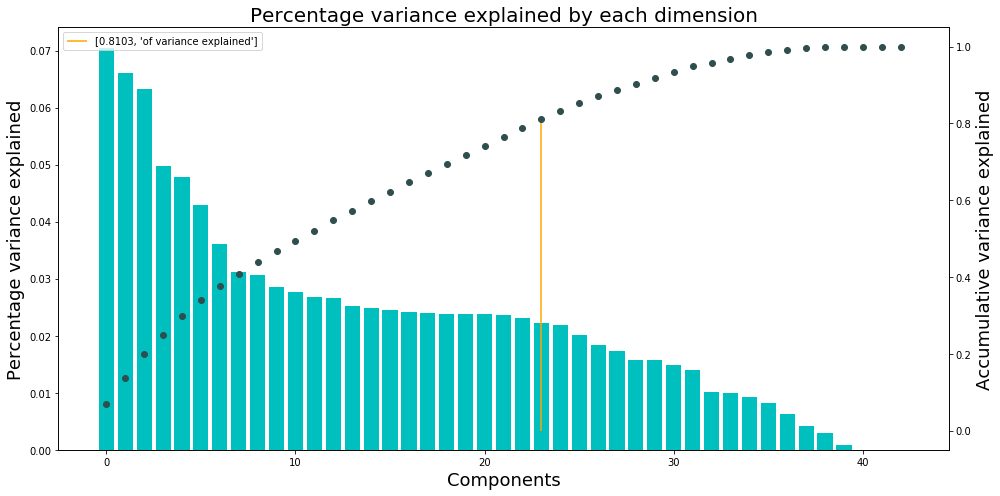

In [13]:
ac_var = 0
x = 0
bar = True

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xlabel('Components',fontsize=18)
plt.ylabel('Percentage variance explained', fontsize=18)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(ac_var)  # we already handled the x-label with ax1
plt.ylabel('Accumulative variance explained', fontsize=18)

while x < X_train_pca.shape[1]:
    ax1.tick_params(axis='y')
    ax1.bar(x, pca.explained_variance_ratio_[x], width=0.8, color="c") #Eigenvalues
    ac_var = pca.explained_variance_ratio_[x] + ac_var
    ax2.plot(x, ac_var, linestyle='-', marker='o',color="darkslategray")
    if ac_var > 0.8 and bar == True:
        plt.vlines(x, 0, ac_var, colors="orange", linestyles='solid', label = [round(ac_var,5),'of variance explained'] )
        bar = False
    x = x + 1

plt.title('Percentage variance explained by each dimension',fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In some dataset all the features are contributing equally to the overall variance, therefore all the principal components are crucial to the predictions and none can be ignored.

In [14]:
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
smt = SMOTETomek()
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

In [15]:
print('Number of instances on the initial X: {}'.format(np.shape(features_X)[0]))

print('\nNumber of instances in X_train: {}'.format(X_train_res.shape))
print('Number of instances in y_train: {}'.format(y_train_res.shape))
print('Number of instances in X_test: {}'.format(X_test.shape))
print('Number of instances in y_test: {}'.format(y_test.shape))

print('Resampled dataset shape {}'.format(Counter(y_train_res)))


Number of instances on the initial X: 20410

Number of instances in X_train: (44967, 43)
Number of instances in y_train: (44967,)
Number of instances in X_test: (5103, 43)
Number of instances in y_test: (5103,)
Resampled dataset shape Counter({0: 14989, 1: 14989, 2: 14989})


In [16]:
param_grid = { 
    'n_estimators': [200, 500, 1000],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,10,30],
#     'criterion' :['gini', 'entropy']
}


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import time

start = time.time()

# Random forest
clf_rf = RandomForestClassifier(criterion='gini',
                                random_state=0, 
                                class_weight="balanced")

clf_rf_grid = GridSearchCV(clf_rf, param_grid, cv=3, n_jobs=-1)

# Train model
model = clf_rf_grid.fit(X_train_res, y_train_res)

In [18]:
end = time.time()

In [19]:
print(end - start)
from sklearn.metrics import classification_report
print(classification_report(y_test,clf_rf_grid.predict(X_test)))

691.3913497924805
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5004
           1       0.57      0.18      0.27        91
           2       1.00      0.38      0.55         8

   micro avg       0.98      0.98      0.98      5103
   macro avg       0.85      0.52      0.60      5103
weighted avg       0.98      0.98      0.98      5103



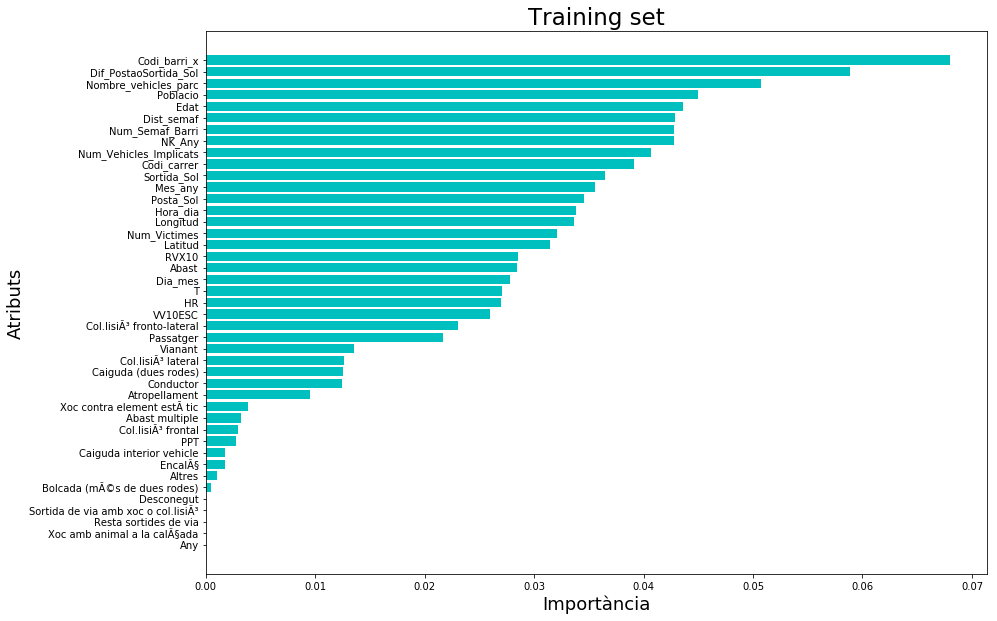

In [20]:
imp = clf_rf_grid.best_estimator_.feature_importances_
names = features_X.columns

imp, names = zip(*sorted(zip(imp, names)))

fig = plt.figure(figsize=(14,10))
ax = fig.gca()

plt.barh(range(len(names)),imp, align = 'center', color='c')
plt.yticks(range(len(names)), names)

ax.set_ylabel('Atributs', size = 18)
ax.set_xlabel('Importància', size = 18)
ax.set_title('Training set', size = 23)

plt.show()

The cost-sensitive approach would be to assign different weights to different classes. So if the minority class is assigned a higher weight and thus higher misclassification cost, then that can help reduce its biasness towards the majority class. You can use the class weight parameter of random forest in scikit-learn to assign weights to each class.

In [21]:
y_pred = clf_rf_grid.predict(X_train_res) 
y_test_pred = clf_rf_grid.predict(X_test)

In [22]:
print('Classification accuracy on training set: {:.5f}'.format(accuracy_score(y_train_res,y_pred)))
# print('Log Loss on training set: {:.5f}'.format(log_loss(y_train,y_pred)))

print('\nClassification accuracy on test set: {:.5f}'.format(accuracy_score(y_test,y_test_pred))) 
# print('Log Loss on test set: {:.5f}'.format(log_loss(y_test,y_test_pred))) 

Classification accuracy on training set: 0.99996

Classification accuracy on test set: 0.98197


In [23]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="prior").fit(X_train, y_train) 
pred_y_d = dummy_classifier.predict(X_test)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(y_test,pred_y_d)))
# print('Log Loss of the Dummy Classifier: {:.5f}'.format(log_loss(y_test,pred_y_d))) 

Dummy Classifier accuracy on the test set: 0.98060


In [24]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    fig = plt.figure(figsize=(10,7))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title, size=18)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()

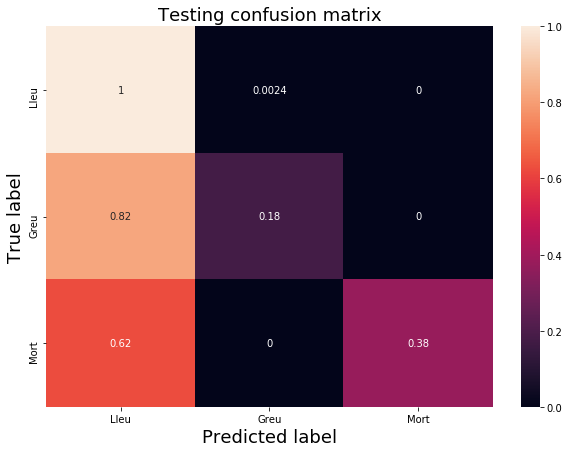

In [25]:
cm = confusion_matrix(y_test,y_test_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm, classes=['Lleu', 'Greu', 'Mort'], title='Testing confusion matrix')
plt.show()